In [1]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import pickle

from time import perf_counter

# INF 554 Lab 2: Low Rank Approximation and Denoising of Images


In this lab we will use the PCA, MDS and SVD algorithms presented in Lecture 1 to obtain low rank approximations and denoise images.



## 1) Low Rank Approximation

In this lab, we will be working with images, where each pixel is encoded by four values, namely RGBA (red, green, blue, alpha). These four dimensions encoding each pixel will be referred to as the four channels of our images. You should create low rank approximations separately for each channel, i.e., to obtain a low rank approximation for the images, you should separately calculate the low rank approximation for each channel of the input image and then concatenate these low rank approximations. Therefore, in this lab our data  will be denoted by $X_i \in R^{n\times m}$ for $i \in \{R,G,B,A\}.$




Now we load the image you will be working with in this lab.





Data type:  <class 'numpy.ndarray'>
Shape:  (522, 300, 4)


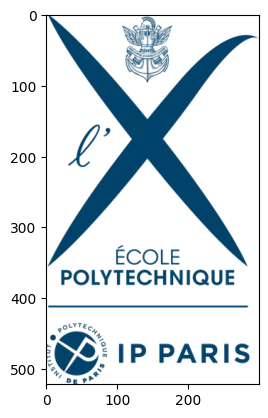

In [7]:
logo = mpimg.imread('IPPX_logo.png') 

print("Data type: ", type(logo)); print("Shape: ", logo.shape)

plt.imshow(logo) 
plt.show()


We begin by briefly summarising the first, and simplest, method, the singular value decomposition (SVD), that we use for low-rank approximation in this lab.  

**SVD:** Consider the singular value decomposition of $X_i = V \Sigma W^T$ (recall the [definition of the svd](http://theanalysisofdata.com/probability/C_5.html)). Further, let $V_k \in R^{n\times k},$ $W_k \in R^{m\times k}$ and $\Sigma_k \in R^{k\times k}$ contain the first $k$ left and right singular vectors and the largest $k$ singular values, respectively. Then, the singular value low rank approximation, denoted $\tilde{X}_i^{SVD},$ of $X_i$ is obtained as follows,
\begin{equation}
\tilde{X}_i^{SVD} = V_k \Sigma_k W_k^T.
\end{equation}



>**Task 1:** Complete the below functions to calculate low rank approximations of an input image with 4 channels using the SVD algorithm. Feel free to make use of the ``np.linalg.svd()`` function.

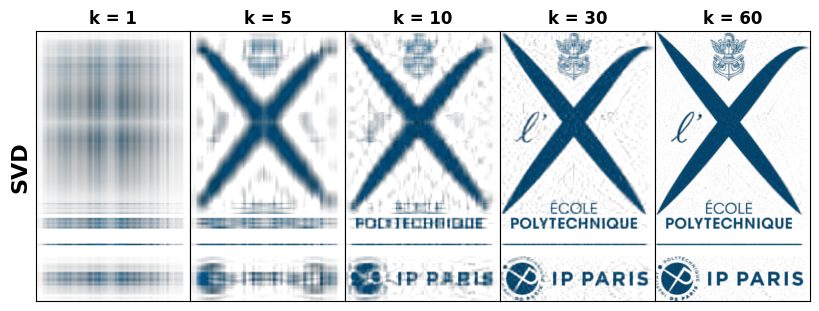

In [29]:
def svd(X, k):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    """
    
    n, m, d = X.shape #extract dimension parameters from X
    X_low_rank_approx = np.zeros(X.shape)

    for i in range(d): # we perform SVD for each channel
        V, Sigma, Wt = np.linalg.svd(X[:,:,i], full_matrices=False)
        X_k_svd = V[:,:k] @ np.diag(Sigma[:k]) @ Wt[:k,:] #we crop each matrix as needed for low rank approx
        X_low_rank_approx[:,:,i] = X_k_svd
    return X_low_rank_approx


k_values = [1,5,10,30,60]
fig, axs = plt.subplots(1,5, figsize=(8,3))
titles = ['k = 1','k = 5','k = 10','k = 30','k = 60']
axs[0].set_ylabel('SVD', fontsize=16,fontweight='bold')
for j in range(5):
    axs[j].set_title(titles[j], fontweight='bold')
    axs[j].imshow(np.clip(svd(logo,k_values[j]),0,1))
    axs[j].set_xticks([])
    axs[j].set_yticks([])
fig.tight_layout(pad=0)




We now turn to the Principal Component Analysis (PCA) and Multidimensional Scaling (MDS) algorithms. 


**PCA:** Let $M_i\in R^{n\times m} $ be the matrix containing the column means of $X_i$ in each column. Further, let $C_i = X_i -  M_i$ denote the data matrix $X_i,$ where the column mean is substracted from each column. Furthermore, let $U_k\in R^{m\times k}$ denote the right singular vectors of $C_i$ corresponding to the largest $k$ singular values (note that the right singular vectors of $C_i$ correspond to the eigenvectors of the covariance matrix $C_i^T C_i/n$ and are faster to compute). Then, the PCA low-rank approximation, denoted $\tilde{X}_i^{PCA},$ of $X_i$ is obtained as follows,
\begin{equation}
\tilde{X}_i^{PCA} = C_i U_k U_k^T + M_i.
\end{equation}




**MDS:** 
Let $M_i\in R^{n\times m} $ be the matrix containing the column means of $X_i$ in each column. Further, let $C_i = X_i -  M_i$ denote the data matrix $X_i,$ where the column mean is substracted from each column. 
For the multidimensional scaling algorithm we utilise the singular value decomposition of the matrix denoted $C_i C_i^T.$ Let $Q_k \in R^{n\times k}$ denote the matrix containing the $k$ left singular vectors corresponding to the $k$ largest singluar values of $C_i C_i^T.$ Then, the low rank approximation, denoted $\tilde{X}_i^{MDS},$ of $X_i$ is obtained as follows,
\begin{equation}
\tilde{X}_i^{MDS} =  Q_k Q_k^T C_i +M_i.
\end{equation}


>**Task 2:** Similarly to Task 1, we ask you to please complete the below functions to calculate low rank approximations of an input image with 4 channels using the PCA and MDS algorithms. To allow you to understand how these methods function in detail we ask you to please code the methods from first-principles, i.e., to not make use of the relevant scikit learn functions; in the case of the singular value decomposition please do make use of the ``np.linalg.svd()`` function. 

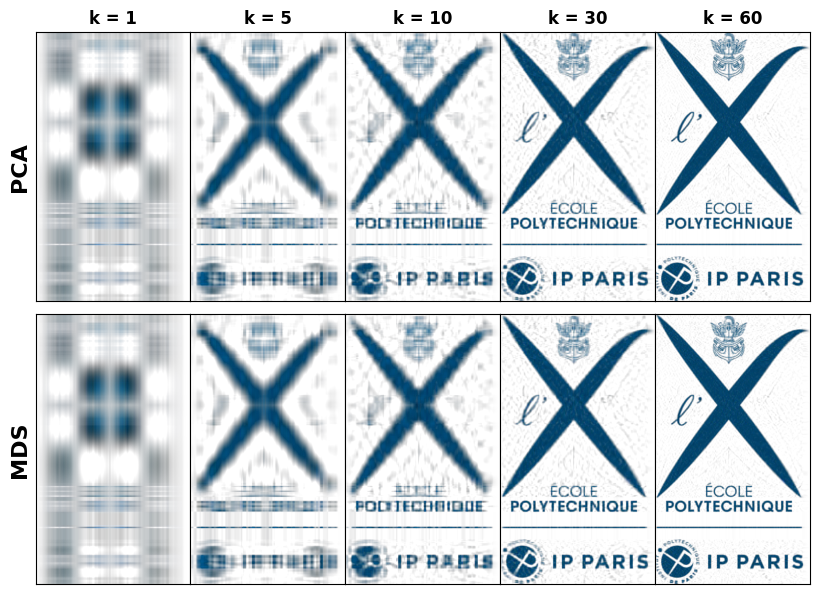

In [35]:
def pca(X, k):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
        U (np.array, dim: m,k,4): singular vectors used to obtain the low rank approximation
    """
    
    n, m, d = X.shape
    X_low_rank_approx = np.zeros(X.shape)
    U = np.zeros((m, k, d))

    for i in range(d):
        Xi = X[:,:,i]
        Mi = np.mean(Xi, axis=0)
        Ci = Xi - Mi
        _, _, U_full = np.linalg.svd(Ci, full_matrices=False)
        Ui = np.transpose(U_full[:k,:])

        X_low_rank_approx[:,:,i] = Ci @ Ui @ np.transpose(Ui) + Mi
        U[:,:,i] = Ui
    
    return X_low_rank_approx, U

def mds(X, k):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    """
    
    n, m, d = X.shape
    X_low_rank_approx = np.zeros(X.shape)

    for i in range(d):
        Xi = X[:,:,i]
        Mi = np.mean(Xi, axis=0)
        Ci = Xi - Mi
        Q_full, _, _ = np.linalg.svd(Ci @ np.transpose(Ci), full_matrices=False)
        Qi = Q_full[:,:k]

        X_low_rank_approx[:,:,i] = Qi @ np.transpose(Qi) @ Ci + Mi
    
    return X_low_rank_approx

k_values = [1,5,10,30,60]
results = np.zeros(logo.shape + tuple([10]))
for j,k in enumerate(k_values):
    results[:,:,:,j], temp1  = pca(logo,k)
    results[:,:,:,5+j] = mds(logo,k)

fig, axs = plt.subplots(2,5, figsize=(8,6))


titles = ['k = 1','k = 5','k = 10','k = 30','k = 60']
methods = ['PCA', 'MDS']
for i in range(2):
    axs[i,0].set_ylabel(methods[i], fontsize=16,fontweight='bold')
    for j in range(5):
        if i==0:
            axs[i,j].set_title(titles[j], fontweight='bold')
        axs[i,j].imshow(np.clip(results[:,:,:,i*5+j],0,1))
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.tight_layout(pad=0)


The quality of the PCA reconstruction is often evaluated by calculating the fraction of the total variance of the image that is preserved in the reconstructed image. Hence, the first evaluation metric we want to use to assess the quality of the reconstruction is the sum of the eigenvalues of the estimated covariance matrix $(\tilde{C}_i^{h})^T \tilde{C}_i^{h}/n$ for $h \in \{\text{SVD, PCA, MDS}\}$ divided by the sum of eigenvalues of the estimated covariance matrix of the original image $C_i^T C_i/n.$ The final metric is produced by averaging the fraction of the sum of eigenvalues over all four image channels.


The performance of the SVD reconstruction is commonly measured using the difference of the original image and the reconstructed image in Frobenius norm. This will be the second metric we will consider to compare our low rank approximations.

>**Task 3:** Fill out the code to calculate the two presented evaluation metrics of our methods. Then use these functions to quanititatively assess the approximation error of our three methods when $k=10.$ Fill your results into the provided table. 

In [43]:
def evals(X, X_low_rank_approx):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    Returns:
        eval_fraction (float): the ratio of the explained variance as described in the problem description
    """
    n, m, d = X.shape
    eval_fraction = 0

    for i in range(d):
        Xi = X[:,:,i]
        Xi_tilde = X_low_rank_approx[:,:,i]

        Mi = np.mean(Xi, axis=0)
        Mi_tilde = np.mean(Xi_tilde, axis=0)

        Ci = Xi - Mi
        Ci_tilde = Xi_tilde - Mi_tilde

        _, Sigma, _ = np.linalg.svd(Ci @ np.transpose(Ci), full_matrices=False)
        _, Sigma_tilde, _ = np.linalg.svd(Ci_tilde @ np.transpose(Ci_tilde), full_matrices=False)

        eval_fraction += np.sum(Sigma_tilde**2)/np.sum(Sigma**2) #we compute the ratio of the sum of eigenvalues for each channel
    
    return eval_fraction/d #and take average of sum of ratios


def Fnorm_difference(X, X_low_rank_approx):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    Returns:
        diff (float): the difference of the two inputs in Frobenius norm
    """
    diff = np.linalg.norm(X - X_low_rank_approx)
    return diff

results_task3 = np.zeros(shape=[3,2])

k = 10

results_task3[0,0] = evals(logo, svd(logo,k))
results_task3[1,0] = evals(logo, pca(logo,k)[0])
results_task3[2,0] = evals(logo, mds(logo,k))

results_task3[0,1] = Fnorm_difference(logo, svd(logo,k))
results_task3[1,1] = Fnorm_difference(logo, pca(logo,k)[0])
results_task3[2,1] = Fnorm_difference(logo, mds(logo,k))

metrics = ['evals', 'norm']
methods = ['SVD', 'PCA', 'MDS']

print('\t',end='')
for j in range(2):
    print(metrics[j], end='\t')
print('')
for i in range(3):
    print(methods[i], end='\t')
    for j in range(2):
        print(np.round(results_task3[i,j],4),'\t', end='')
    print('')


	evals	norm	
SVD	0.9813 	79.635 	
PCA	0.983 	79.4091 	
MDS	0.983 	79.4091 	


Feel free to vary the rank $k$ used in the above reconstructions to quantitatively observe how the quality of the reconstruction varies.

## 2) Image Denoising

In this section we will use the eigenvectors used in the PCA of the original logo to denoise two noisy images of the logo. In the cell below we load the two noisy images.

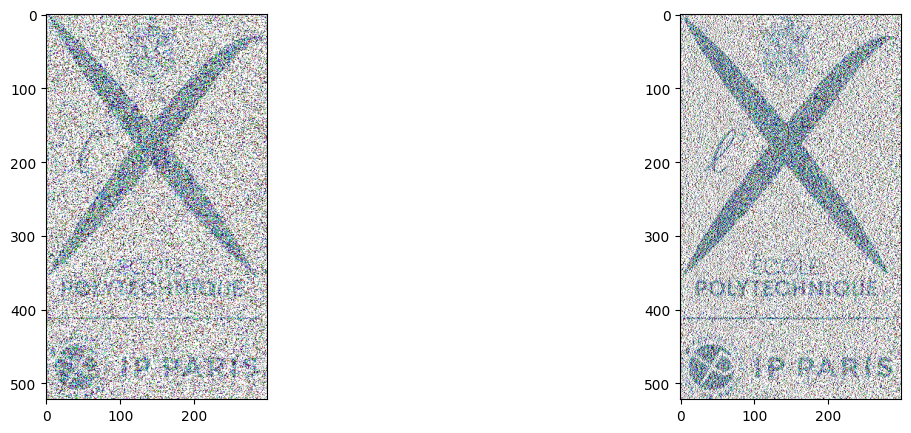

In [39]:
with open('noisy_image1.pickle', 'rb') as f:
    noisy_image1 = pickle.load(f)
    
with open('noisy_image2.pickle', 'rb') as f:
    noisy_image2 = pickle.load(f)
    
fig, axs = plt.subplots(1,2, figsize=(15,5))  
axs[0].imshow(np.clip(noisy_image1,0,1))
axs[1].imshow(np.clip(noisy_image2,0,1))
plt.show()

**Task 4:** Use the eigenvectors used in the PCA algorithm on the original image to obtain low rank approximations of the noisy images. Use the number of eigenvectors which minimises the distance of the denoised image and the original logo in the Frobenius norm metric introduced in Section 1. To find the minimum we recommend you search reconstructions using $\{1, 2, \ldots, 100\}$ eigenvectors. 

In [40]:
#preprocessing
n,m,D = logo.shape

C_noisy1 = np.zeros(logo.shape)
M_noisy1 = np.zeros(logo.shape[1:])
for d in range(D):
    M_noisy1[:,d] = np.mean(noisy_image1[:,:,d],axis=0)  
    C_noisy1[:,:,d] = noisy_image1[:,:,d] - M_noisy1[:,d]

C_noisy2 = np.zeros(logo.shape)
M_noisy2 = np.zeros(logo.shape[1:])
for d in range(D):
    M_noisy2[:,d] = np.mean(noisy_image2[:,:,d],axis=0)  
    C_noisy2[:,:,d] = noisy_image2[:,:,d] - M_noisy2[:,d]


In [ ]:
def search_optimal_reconstruction(logo, C_noisy, M_noisy, k_range):
    """
    Args:
        logo (np.array, dim: n,m,4): containing the clean image
        C_noisy (np.array, dim: n,m,4): containing the centered noisy image, where the each channel was centered individually
        M_noisy (np.array, dim: n,4): containing the channel means of the noised image
        k_range (np.array, 100): range of values to check in the low rank approximation
    Returns:
        approximation_error_F_norm (np.array, 100): the appximation error in Frobenius norm for different denoised images
        denoised_image (np.array, dim: n,m,4): return the last denoised image (for plotting in the next code cell)
    """

    denoised_image = np.zeros(logo.shape)
    n,m,D = logo.shape
    approximation_error_F_norm = np.zeros(len(k_range))

    for i,k in enumerate(k_range):

        #Please insert the code for Task 4 here

        
        
        
    return approximation_error_F_norm, denoised_image

k_range = np.arange(100)

approximation_error_F_norm1, _ = search_optimal_reconstruction(logo, C_noisy1, M_noisy1, k_range)
approximation_error_F_norm2, _ = search_optimal_reconstruction(logo, C_noisy2, M_noisy2, k_range)

fig, axs = plt.subplots(1,2, figsize=(15,5))  
axs[0].plot(k_range, approximation_error_F_norm1,'o')
axs[1].plot(k_range, approximation_error_F_norm2,'o')
plt.show()

print('The minimal Frobenius norm value for noisy image 1 was obtained at k=%d.' %(k_range[np.argmin(approximation_error_F_norm1)]))
print('The minimal Frobenius norm value for noisy image 2 was obtained at k=%d.' %(k_range[np.argmin(approximation_error_F_norm2)]))

In [ ]:
denoised_image1 = np.zeros(logo.shape)
denoised_image2 = np.zeros(logo.shape)



k1_optimal = k_range[np.argmin(approximation_error_F_norm1)]
k2_optimal = k_range[np.argmin(approximation_error_F_norm2)]

_, denoised_image1 = search_optimal_reconstruction(logo, C_noisy1, M_noisy1, [k1_optimal])
_, denoised_image2 = search_optimal_reconstruction(logo, C_noisy2, M_noisy2, [k2_optimal])
    

fig, axs = plt.subplots(1,5, figsize=(15,5))    
axs[0].imshow(logo)
axs[1].imshow(np.clip(noisy_image1,0,1))
axs[2].imshow(np.clip(denoised_image1,0,1))
axs[3].imshow(np.clip(noisy_image2,0,1))
axs[4].imshow(np.clip(denoised_image2,0,1))



titles = ['original', 'noisy logo 1', 'k= %d'%(k1_optimal), 'noisy logo 2', 'k= %d'%(k2_optimal)]
for i in range(5):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(titles[i], fontweight='bold')
fig.tight_layout(pad=0)



**Question:** Comment on how the low rank approximation affects the level of noise in the images and explain the observed change in the level of noise visible in the low rank approximations. Are you able to draw conclusions about the structural properties of the noise added to the two images from your success in denoising them?